Import file with Gmail App Password

In [1]:
import credentials
import pandas as pd

In [2]:
btc = pd.read_csv('BTC-USD.csv')
btc.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'],inplace=True)
btc

,Date,Adj Close
0,2019-02-20,3999.820557
1,2019-02-21,3954.118164
2,2019-02-22,4005.526611
3,2019-02-23,4142.526855
4,2019-02-24,3810.427490
...,...,...
1822,2024-02-16,52160.203125
1823,2024-02-17,51662.996094
1824,2024-02-18,52122.546875
1825,2024-02-19,51779.144531


Add tickers of companies that I am interested in right now


In [3]:
tickers = ['TSLA','^GSPC', 'RIVN', 'AAPL', 'NVDA', 'DIS','MSFT','NFLX','LCID','BUD','BB','PYPL','PLTR', 'FSR','AMD','COIN','^SPX','^NDX', 'ARM', 'ABNB', 'AMD', 'AN', 'HOOD', 'NOC','TLT','IBIT', 'IWM', 'NVO', 'BRK-A', 'AMZN' ]
tickers = list(set(tickers))
tickers

['HOOD',
 'BUD',
 'PYPL',
 'TSLA',
 'IBIT',
 'NVO',
 'RIVN',
 'NVDA',
 'TLT',
 'PLTR',
 'DIS',
 'NOC',
 '^NDX',
 '^GSPC',
 'ARM',
 'AN',
 'AMD',
 'AMZN',
 'AAPL',
 'IWM',
 'LCID',
 '^SPX',
 'NFLX',
 'ABNB',
 'BB',
 'BRK-A',
 'FSR',
 'COIN',
 'MSFT']

In [4]:
#tickers = pd.read_csv('nasdaq_screener.csv')
#tickers = tickers['Symbol'].tolist()

In [5]:
# tickers_hand = ['TSLA','^GSPC', 'RIVN', 'AAPL', 'NVDA', 'DIS','MSFT','NFLX','LCID','BUD','BB','PYPL','PLTR', 'FSR','AMD','COIN','^SPX','^NDX', 'ARM', 'ABNB', 'AMD', 'AN', 'HOOD', 'NOC','TLT','IBIT', 'IWM', 'NVO' ]
# tickers_sp = pd.read_html(
#     'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
# tickers_nasdaq = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4]
# tickers_sp = tickers_sp.iloc[:,0].tolist()
# tickers_nasdaq = tickers_nasdaq.iloc[:,1].tolist()
# tickers_combined = tickers_sp + tickers_nasdaq + tickers_hand
# tickers = list(set(tickers_combined))
# tickers = sorted(tickers)


1. dodać mój indykator 
2. dodac liste najbardziej oddalonych od upper i lower


In [6]:
#import all neccessary libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import timedelta
import datetime as dt

#get start and end days for the data download
start_date = (pd.Timestamp.today() - timedelta(days=3600)).strftime('%Y-%m-%d')
start_date_h = (pd.Timestamp.today() - timedelta(days=7)).strftime('%Y-%m-%d')
end_date = (pd.Timestamp.today()).strftime('%Y-%m-%d')
day_of_week = (pd.Timestamp.today()).strftime('%A')
#prepare empty dataframes
prices_df = pd.DataFrame()
percentage_change_df = pd.DataFrame()
weekly_pct_change_df = pd.DataFrame()
h_prices_df = pd.DataFrame()

#loop to get yfinance data for all tickers, prepare it and then visualise and save
for ticker in tickers:
    #download and manipulate the data
    data = yf.download(ticker, start=start_date, end=end_date, actions=True)
    print(ticker)
    prices_df[ticker] = data['Adj Close']
    h_data = yf.download(ticker, start=start_date_h, end=end_date, actions=True, interval='5m')
    h_prices_df[ticker] = h_data['Adj Close'].reset_index(drop=True)
    percentage_change_df[ticker] = data['Adj Close'].pct_change() * 100
    weekly_data = (1 - (prices_df[:1].reset_index(drop=True) / prices_df[-1:].reset_index(drop=True))) * 100
    daily_data = (1 - (prices_df[-2:-1].reset_index(drop=True) / prices_df[-1:].reset_index(drop=True))) * 100

    datetime_index = pd.to_datetime(h_data.index)
    #get all of the days in the date range
    datetime_series = pd.Series(datetime_index)
    unique_dates = datetime_series.dt.strftime('%Y-%m-%d').unique()

    # #create weekly price chart
    # plt.figure(figsize=(10, 6))
    # plt.plot(h_prices_df.index, h_prices_df[ticker], label=ticker)
    # plt.xlabel('Date')
    # plt.ylabel('Price')
    # plt.title(f'Weekly Price Movement - {ticker}')
    # plt.legend()

    # #add vertical lines indicating different days 
    # num_data_points = 390
    # vertical_lines_indices = range(0, num_data_points, 78)
    # for i,index in enumerate(vertical_lines_indices):
    #     plt.axvline(x=h_prices_df.index[index], color='gray', linestyle='--')
    #     #add text with dates to indicate the days
    #     plt.text(
    #             h_prices_df.index[index]+20,
    #             (h_prices_df[ticker]).min()-(h_prices_df[ticker].max() - h_prices_df[ticker].min())*0.01,
    #             unique_dates[i],
    #             rotation=0,
    #             va='top',
    #             ha='left',
    #             color='black'
    #         )


    # plt.xticks(rotation=45)
    # plt.xlim(0, h_prices_df.index[-1])
    # plt.xticks([])

    # plt.tight_layout()

    # #save charts to png
    # #plt.savefig(f'{ticker}_weekly_price_movement.png')
    # plt.close()


[*********************100%***********************]  1 of 1 completed
HOOD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
BUD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
PYPL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
TSLA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
IBIT
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
NVO
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
RIVN
[*********************100%***********************]  1 of 1 completed
[

In [7]:
prices_df.index = pd.to_datetime(prices_df.index)
prices_df.index = prices_df.index.strftime('%Y-%m-%d')

btc.set_index('Date',inplace = True)
btc = btc.rename(columns = {'Adj Close':'BTC'})
prices_df = prices_df.merge(btc,left_index=True, right_index=True, how='left')
prices_df

,HOOD,BUD,PYPL,TSLA,IBIT,NVO,RIVN,NVDA,TLT,PLTR,...,LCID,^SPX,NFLX,ABNB,BB,BRK-A,FSR,COIN,MSFT,BTC
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-29,34.820000,63.336132,283.170013,225.783340,NaN,42.744350,NaN,196.290543,139.035629,22.180000,...,23.350000,4419.149902,514.250000,143.470001,10.35,420676.0,16.510000,235.779999,279.777924,40008.421875
2021-07-30,35.150002,61.566746,275.529999,229.066666,NaN,43.319759,NaN,194.663300,139.689590,21.709999,...,23.719999,4395.259766,517.570007,144.009995,10.16,418900.0,16.120001,236.580002,278.225281,42235.546875
2021-08-02,37.680000,61.537422,270.989990,236.556671,NaN,43.506889,NaN,197.169083,140.935547,22.100000,...,23.770000,4387.160156,515.150024,145.490005,10.10,418695.0,15.960000,235.399994,278.137360,39201.945313
2021-08-03,46.799999,61.107296,273.500000,236.580002,NaN,43.563026,NaN,197.817947,141.010345,22.240000,...,23.580000,4423.149902,510.820007,145.649994,10.17,423706.0,14.800000,230.179993,280.383423,38152.980469
2021-08-04,70.389999,59.973324,275.500000,236.973328,NaN,45.944210,NaN,202.400299,141.300369,22.299999,...,22.629999,4402.660156,517.349976,147.399994,9.87,419962.0,14.770000,244.360001,279.787689,39747.503906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-12,12.010000,64.779999,60.090000,188.130005,28.660000,120.529999,16.330000,722.479980,93.959999,25.049999,...,3.590000,5021.839844,557.849976,153.800003,2.81,597092.0,0.790000,147.309998,414.493500,49958.222656
2024-02-13,11.840000,63.680000,58.259998,184.020004,28.219999,119.989998,15.380000,721.280029,92.349998,24.010000,...,3.320000,4953.169922,554.520020,150.820007,2.71,593850.0,0.750000,140.389999,405.570007,49742.441406
2024-02-14,13.380000,62.349998,58.869999,188.710007,29.549999,123.290001,15.540000,739.000000,92.820000,25.190001,...,3.450000,5000.620117,579.330017,148.199997,2.78,601000.0,0.750000,160.380005,409.489990,51826.695313


In [8]:
indicator_df = prices_df.copy()
for ticker in indicator_df.columns:
    indicator_df[ticker] = indicator_df[ticker] - indicator_df[ticker].rolling(window = 240).mean()
indicator_df = indicator_df.fillna(method='bfill')
indicator_df = indicator_df.fillna(value=0)


for ticker in indicator_df.columns:
    indicator_df[ticker + '_upper_50'] = indicator_df[ticker].rolling(window = 45).mean() + abs(indicator_df[ticker].rolling(window = 90).mean())*0.5
    indicator_df[ticker + '_lower_50'] = indicator_df[ticker].rolling(window = 45).mean() - abs(indicator_df[ticker].rolling(window = 90).mean())*0.5
    indicator_df[ticker + '_rolling_50'] = indicator_df[ticker].rolling(window = 50).mean()
    indicator_df[ticker + '_upper_threshold'] = (indicator_df[ticker].shift(1) > indicator_df[ticker + '_upper_50']) & (indicator_df[ticker] < indicator_df[ticker + '_upper_50'])
    indicator_df[ticker + '_lower_threshold'] = (indicator_df[ticker].shift(1) < indicator_df[ticker + '_lower_50']) & (indicator_df[ticker] > indicator_df[ticker + '_lower_50'])
    indicator_df[ticker + '_over'] = indicator_df[ticker] > indicator_df[ticker + '_upper_50']
    indicator_df[ticker + '_under'] = indicator_df[ticker] < indicator_df[ticker + '_lower_50']
indicator_df = indicator_df.fillna(method='bfill')
indicator_df = indicator_df.fillna(value=0)

    # indicator_df[ticker + '_ul_distance'] = indicator_df[ticker + '_upper_50'] - indicator_df[ticker + '_lower_50']
    # indicator_df[ticker + '_mag_indicator'] = indicator_df[ticker + '_ul_distance']/indicator_df[ticker + '_ul_distance'].rolling(window = 100).mean()
        # indicator_df[ticker + '_rolling_250'] = indicator_df[ticker].rolling(window = 250).mean()
    # indicator_df[ticker + '_upper_gap'] = (indicator_df[ticker + '_upper_50']-indicator_df[ticker]) / indicator_df[ticker + '_upper_50']
    # indicator_df[ticker + '_lower_gap'] = ((indicator_df[ticker] - indicator_df[ticker + '_lower_50']) / indicator_df[ticker])*100
    # indicator_df[ticker + '_distance'] = abs(indicator_df[ticker].rolling(window = 250).mean()-indicator_df[ticker])/indicator_df[ticker].rolling(window = 250).mean()

indicator_df

/var/folders/t5/l1t1fh155v915jtxdt8k6bw80000gn/T/ipykernel_33511/1150365506.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  indicator_df[ticker + '_lower_50'] = indicator_df[ticker].rolling(window = 45).mean() - abs(indicator_df[ticker].rolling(window = 90).mean())*0.5
/var/folders/t5/l1t1fh155v915jtxdt8k6bw80000gn/T/ipykernel_33511/1150365506.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  indicator_df[ticker + '_rolling_50'] = indicator_df[ticker].rolling(window = 50).mean()
/var/folders/t5/l1t1fh155v915jtxdt8k6bw800

,HOOD,BUD,PYPL,TSLA,IBIT,NVO,RIVN,NVDA,TLT,PLTR,...,MSFT_lower_threshold,MSFT_over,MSFT_under,BTC_upper_50,BTC_lower_50,BTC_rolling_50,BTC_upper_threshold,BTC_lower_threshold,BTC_over,BTC_under
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-29,-14.556500,-3.487994,-97.191500,-59.673645,0.0,1.985086,-20.987396,-80.184504,-19.178928,-7.398834,...,False,False,False,-11867.412638,-35602.237914,-23734.825276,False,False,False,False
2021-07-30,-14.556500,-3.487994,-97.191500,-59.673645,0.0,1.985086,-20.987396,-80.184504,-19.178928,-7.398834,...,False,False,False,-11867.412638,-35602.237914,-23734.825276,False,False,False,False
2021-08-02,-14.556500,-3.487994,-97.191500,-59.673645,0.0,1.985086,-20.987396,-80.184504,-19.178928,-7.398834,...,False,False,False,-11867.412638,-35602.237914,-23734.825276,False,False,False,False
2021-08-03,-14.556500,-3.487994,-97.191500,-59.673645,0.0,1.985086,-20.987396,-80.184504,-19.178928,-7.398834,...,False,False,False,-11867.412638,-35602.237914,-23734.825276,False,False,False,False
2021-08-04,-14.556500,-3.487994,-97.191500,-59.673645,0.0,1.985086,-20.987396,-80.184504,-19.178928,-7.398834,...,False,False,False,-11867.412638,-35602.237914,-23734.825276,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-12,1.837521,5.319142,-4.198291,-36.576953,0.0,30.489979,-1.757708,301.268131,-1.552960,10.326291,...,False,False,False,18835.767536,7980.927796,13450.993268,False,False,False,False
2024-02-13,1.658729,4.201603,-5.963460,-40.608829,0.0,29.740110,-2.706125,298.008177,-3.142852,9.218292,...,False,False,False,18967.914682,7950.236256,13597.567712,False,False,False,False
2024-02-14,3.183063,2.863057,-5.290001,-35.909701,0.0,32.817997,-2.545375,313.619967,-2.658290,10.326542,...,False,False,False,19140.113797,7933.102813,13765.781326,False,False,True,False


In [9]:
upper_threshold = indicator_df.filter(regex = '_upper_threshold')
upper_threshold = upper_threshold.tail()
upper_threshold = upper_threshold.any(axis=0)
upper_threshold = upper_threshold[upper_threshold].index.tolist()

lower_threshold = indicator_df.filter(regex = '_lower_threshold')
lower_threshold = lower_threshold.tail()
lower_threshold = lower_threshold.any(axis=0)
lower_threshold = lower_threshold[lower_threshold].index.tolist()



In [10]:
over = indicator_df.filter(regex = '_over')
over = over.tail()
over = over.any(axis=0)
over = over[over].index.tolist()

under = indicator_df.filter(regex = '_under')
under = under.tail()
under = under.any(axis=0)
under = under[under].index.tolist()


In [11]:
under = indicator_df.filter(regex = '_under')
under = under.tail()
under = under.any(axis=0)
under = under[under].index.tolist()
under

['BUD_under',
 'TSLA_under',
 'RIVN_under',
 'TLT_under',
 'NOC_under',
 'AN_under',
 'AAPL_under',
 'BB_under']

In [12]:
indicator_df.index = pd.to_datetime(indicator_df.index)


Upper Threshold Graphs

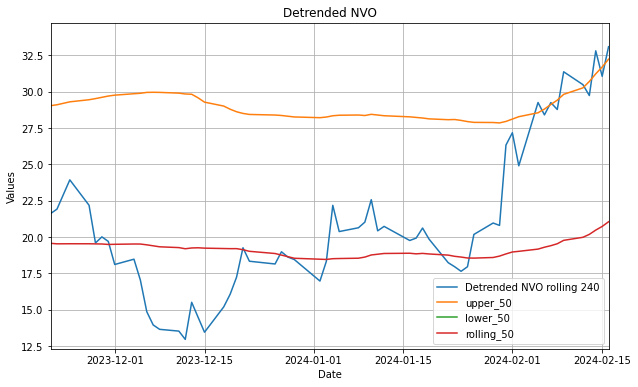

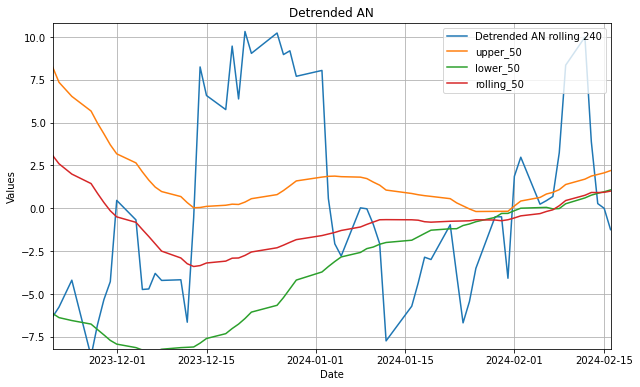

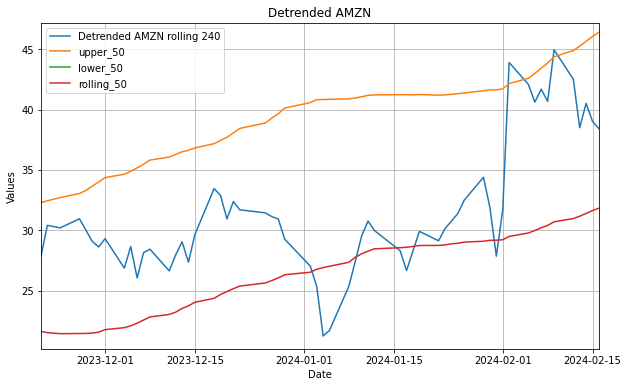

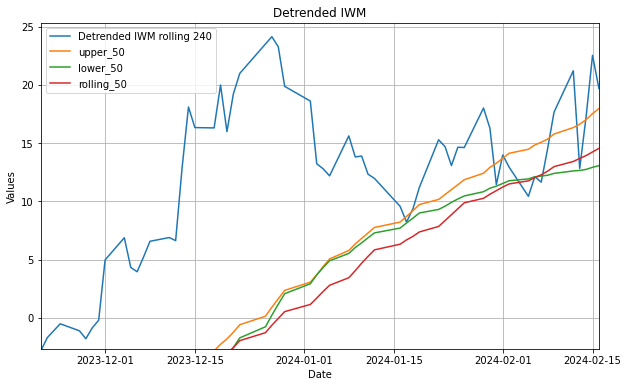

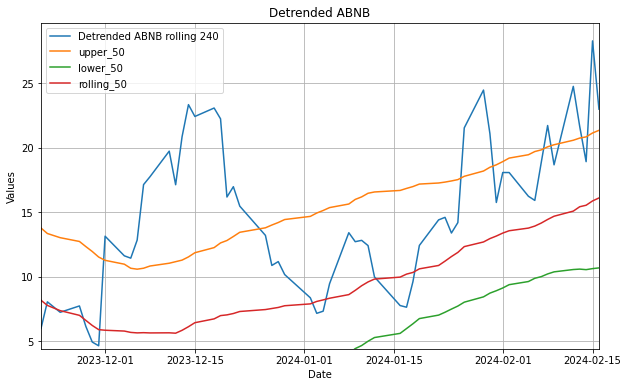

In [13]:
for i in upper_threshold:
    tckr = str(i).split("_")[0]
    plt.figure(figsize=(10, 6))
    plt.plot(indicator_df.index, indicator_df[f'{tckr}'], label=f'Detrended {tckr} rolling 240')
    plt.plot(indicator_df.index, indicator_df[f'{tckr}_upper_50'], label='upper_50')
    plt.plot(indicator_df.index, indicator_df[f'{tckr}_lower_50'], label='lower_50')
    plt.plot(indicator_df.index, indicator_df[f'{tckr}_rolling_50'], label='rolling_50')

    start_date = indicator_df.index[-60]
    end_date = indicator_df.index[-1]
    min_val = indicator_df.loc[start_date:end_date, f'{tckr}'].min()
    max_val = indicator_df.loc[start_date:end_date, f'{tckr}'].max()

    plt.xlim(start_date, end_date)
    plt.ylim(min_val-min_val*0.05, max_val+max_val*0.05)

    plt.title(f'Detrended {tckr}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

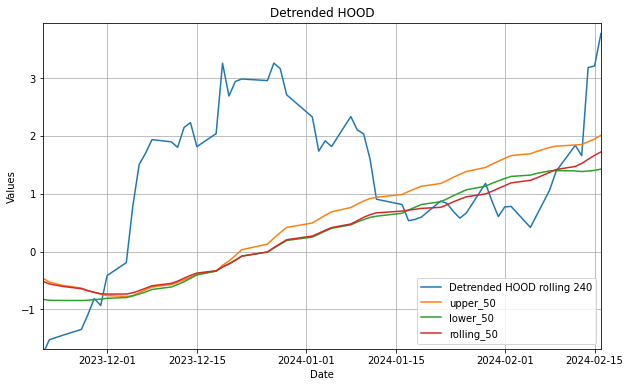

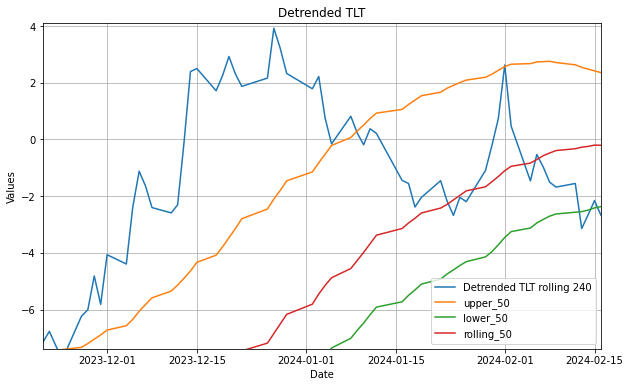

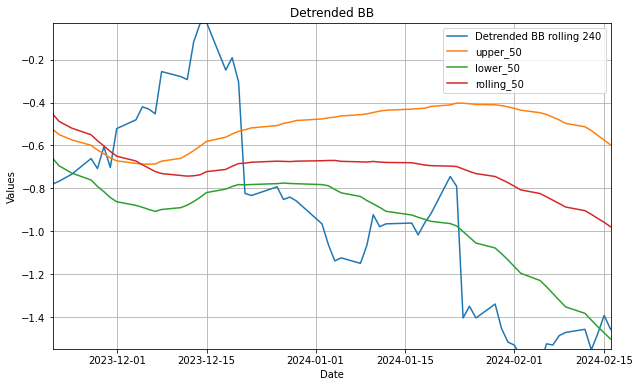

In [14]:
for i in lower_threshold:
    tckr = str(i).split("_")[0]
    plt.figure(figsize=(10, 6))

    plt.plot(indicator_df.index, indicator_df[f'{tckr}'], label=f'Detrended {tckr} rolling 240')
    plt.plot(indicator_df.index, indicator_df[f'{tckr}_upper_50'], label='upper_50')
    plt.plot(indicator_df.index, indicator_df[f'{tckr}_lower_50'], label='lower_50')
    plt.plot(indicator_df.index, indicator_df[f'{tckr}_rolling_50'], label='rolling_50')

    start_date = indicator_df.index[-60]
    end_date = indicator_df.index[-1]
    min_val = indicator_df.loc[start_date:end_date, f'{tckr}'].min()
    max_val = indicator_df.loc[start_date:end_date, f'{tckr}'].max()

    plt.xlim(start_date, end_date)
    plt.ylim(min_val-min_val*0.05, max_val+max_val*0.05)

    plt.title(f'Detrended {tckr}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

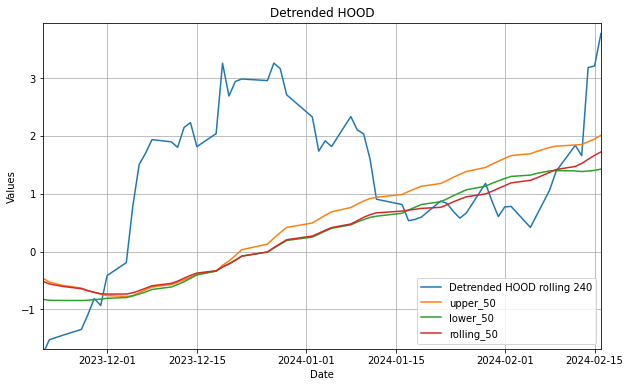

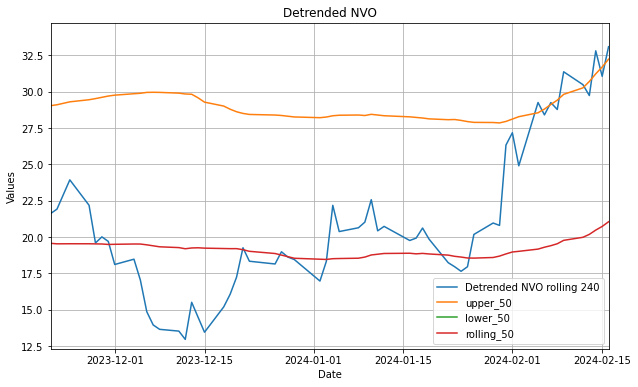

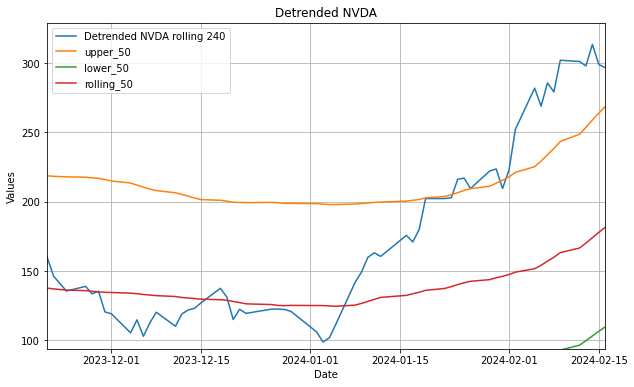

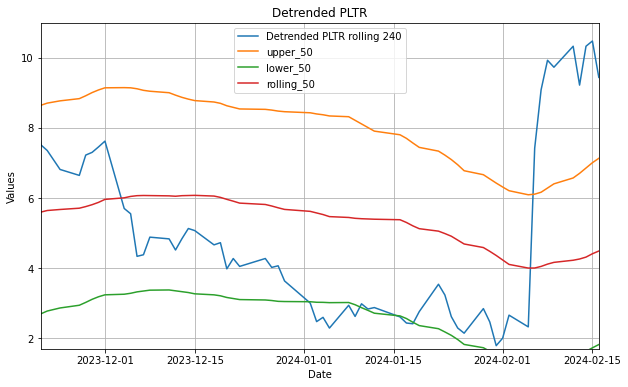

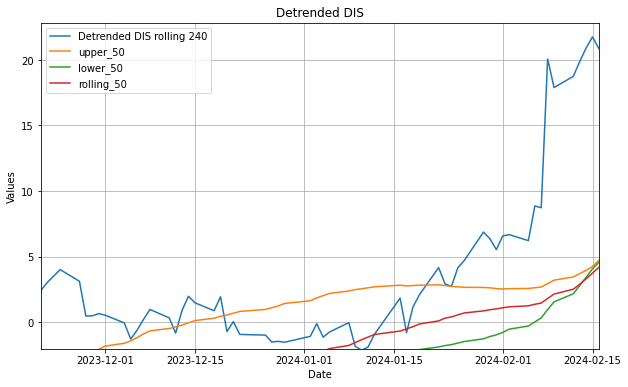

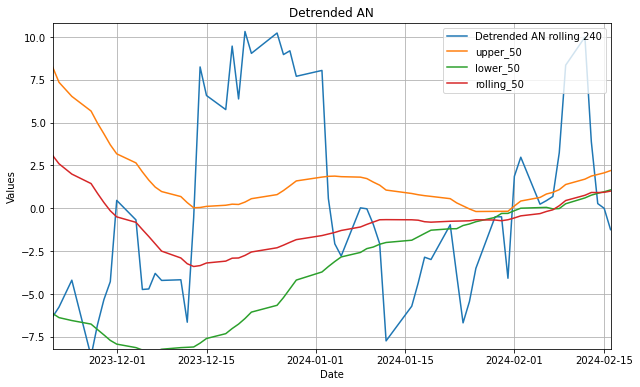

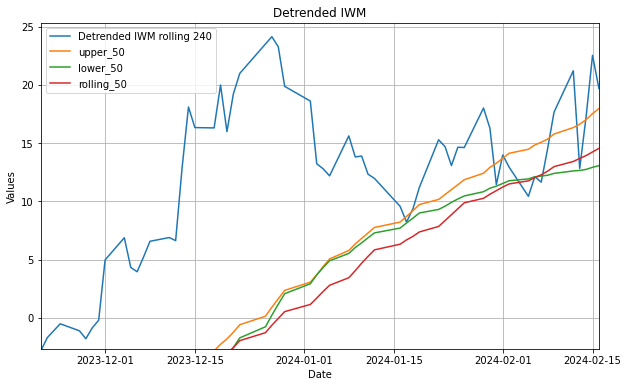

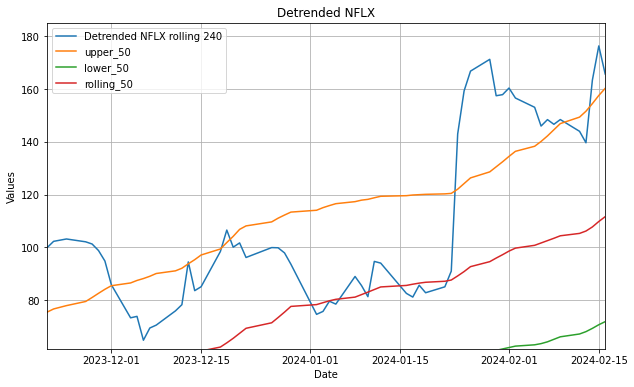

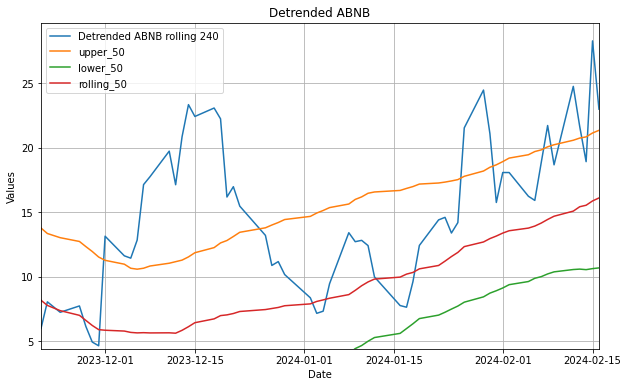

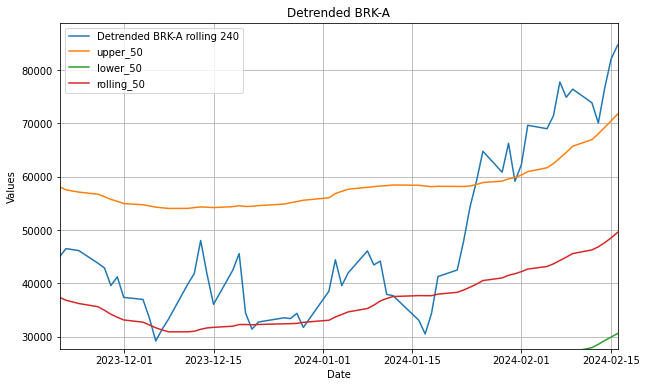

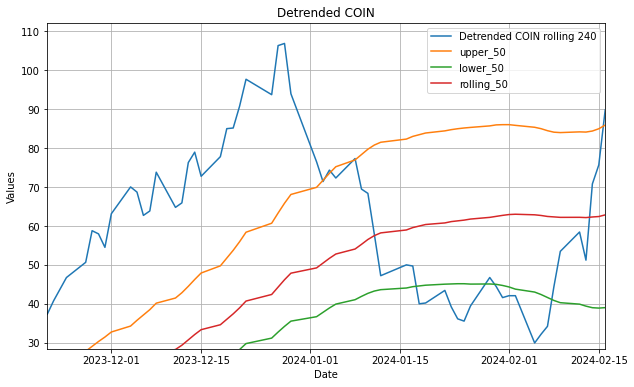

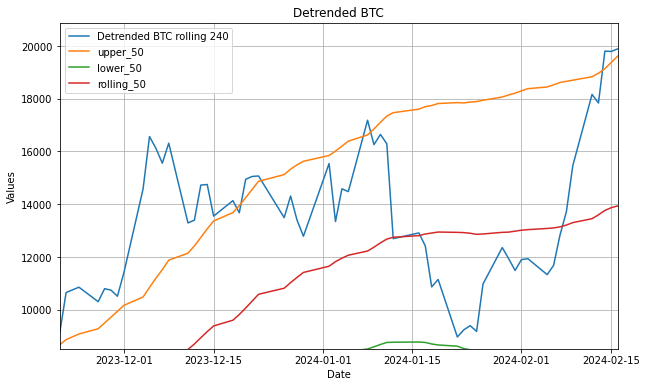

In [15]:
for i in over:
    tckr = str(i).split("_")[0]
    plt.figure(figsize=(10, 6))

    plt.plot(indicator_df.index, indicator_df[f'{tckr}'], label=f'Detrended {tckr} rolling 240')
    plt.plot(indicator_df.index, indicator_df[f'{tckr}_upper_50'], label='upper_50')
    plt.plot(indicator_df.index, indicator_df[f'{tckr}_lower_50'], label='lower_50')
    plt.plot(indicator_df.index, indicator_df[f'{tckr}_rolling_50'], label='rolling_50')

    start_date = indicator_df.index[-60]
    end_date = indicator_df.index[-1]
    min_val = indicator_df.loc[start_date:end_date, f'{tckr}'].min()
    max_val = indicator_df.loc[start_date:end_date, f'{tckr}'].max()

    plt.xlim(start_date, end_date)
    plt.ylim(min_val-min_val*0.05, max_val+max_val*0.05)

    plt.title(f'Detrended {tckr}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

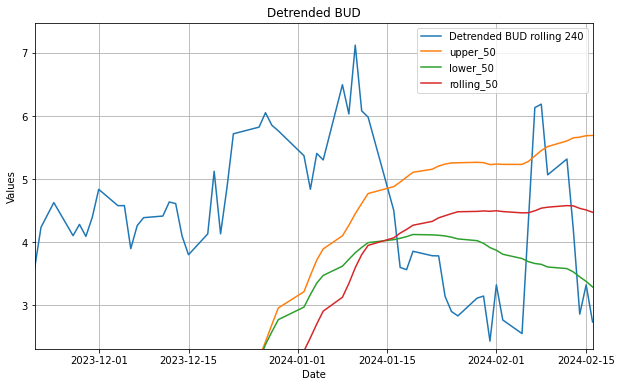

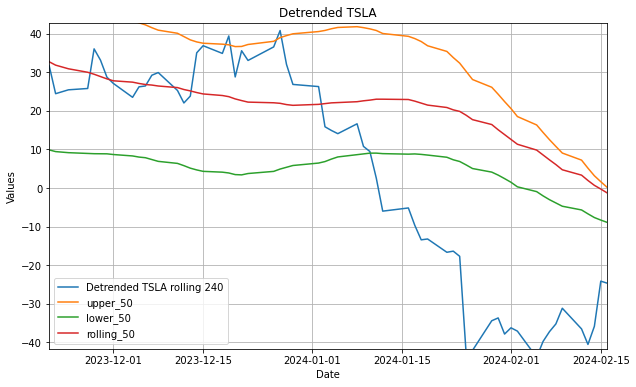

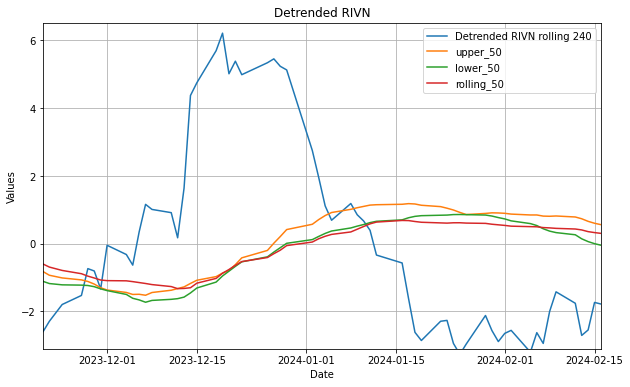

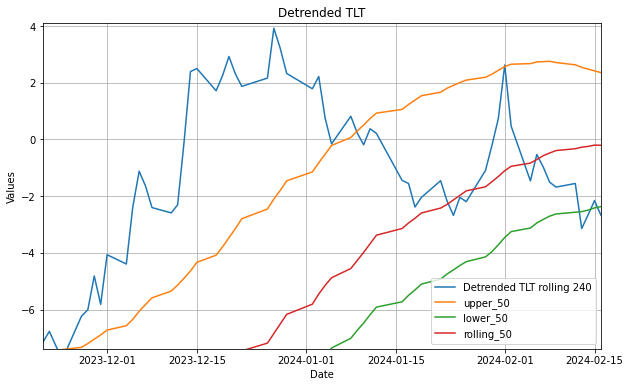

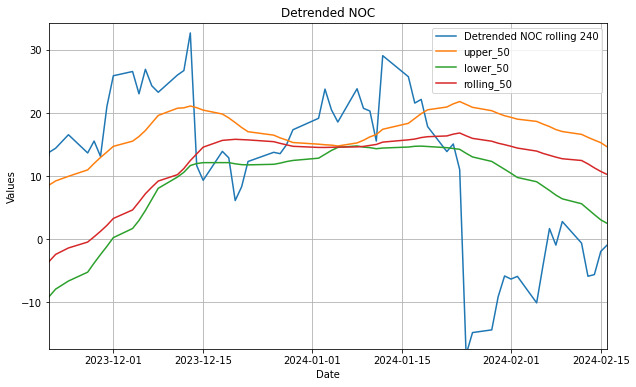

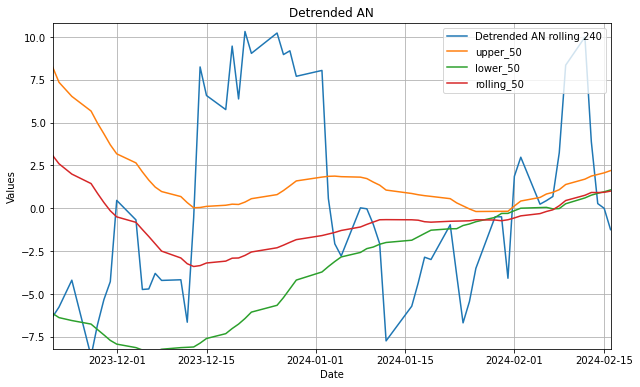

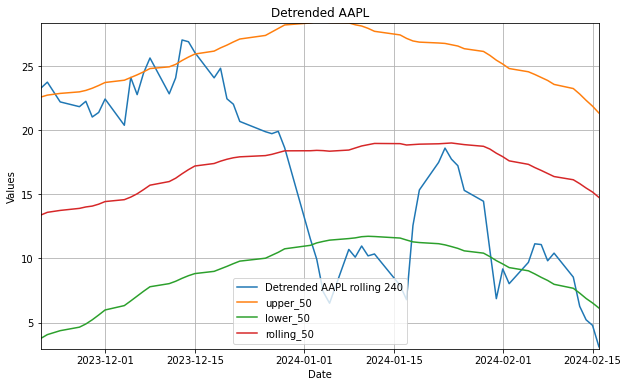

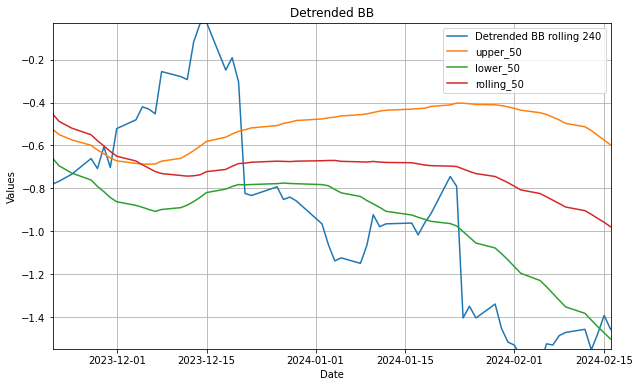

In [16]:
for i in under:
    tckr = str(i).split("_")[0]
    plt.figure(figsize=(10, 6))

    plt.plot(indicator_df.index, indicator_df[f'{tckr}'], label=f'Detrended {tckr} rolling 240')
    plt.plot(indicator_df.index, indicator_df[f'{tckr}_upper_50'], label='upper_50')
    plt.plot(indicator_df.index, indicator_df[f'{tckr}_lower_50'], label='lower_50')
    plt.plot(indicator_df.index, indicator_df[f'{tckr}_rolling_50'], label='rolling_50')

    start_date = indicator_df.index[-60]
    end_date = indicator_df.index[-1]
    min_val = indicator_df.loc[start_date:end_date, f'{tckr}'].min()
    max_val = indicator_df.loc[start_date:end_date, f'{tckr}'].max()

    plt.xlim(start_date, end_date)
    plt.ylim(min_val-min_val*0.05, max_val+max_val*0.05)

    plt.title(f'Detrended {tckr}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

In [29]:
tickers = ['BTC','AMZN','TLT']

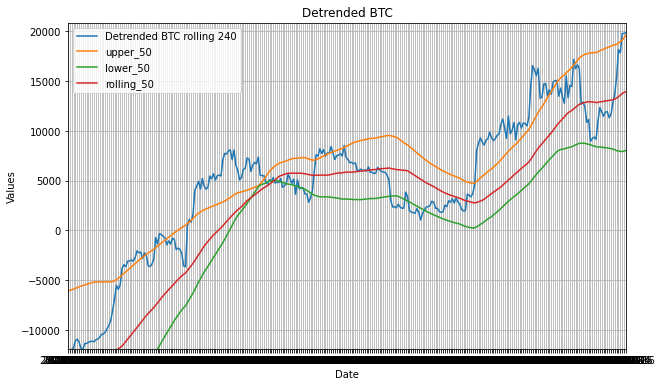

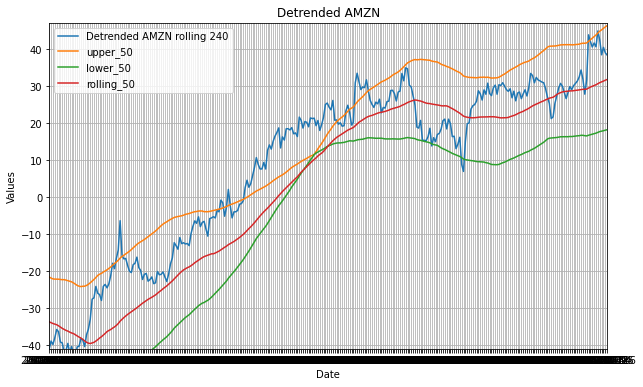

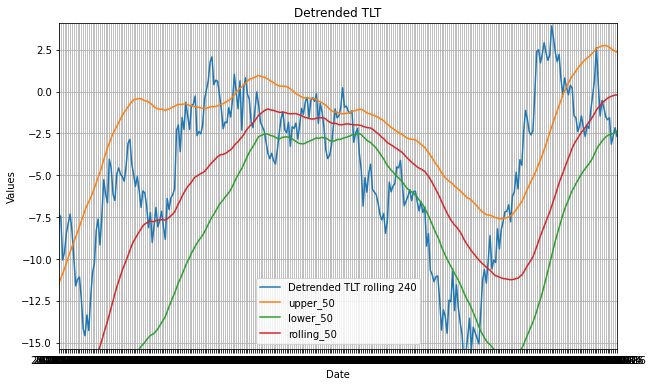

In [30]:
for tckr in tickers:
    plt.figure(figsize=(10, 6))

    plt.plot(indicator_df.index, indicator_df[f'{tckr}'], label=f'Detrended {tckr} rolling 240')
    plt.plot(indicator_df.index, indicator_df[f'{tckr}_upper_50'], label='upper_50')
    plt.plot(indicator_df.index, indicator_df[f'{tckr}_lower_50'], label='lower_50')
    plt.plot(indicator_df.index, indicator_df[f'{tckr}_rolling_50'], label='rolling_50')

    start_date = indicator_df.index[-300]
    end_date = indicator_df.index[-1]
    min_val = indicator_df.loc[start_date:end_date, f'{tckr}'].min()
    max_val = indicator_df.loc[start_date:end_date, f'{tckr}'].max()

    plt.xlim(start_date, end_date)
    plt.ylim(min_val-min_val*0.05, max_val+max_val*0.05)

    plt.title(f'Detrended {tckr}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

dystans miedzy upper i lower bound zmierzyc jako indykator

zmiania kierunku upper i lower

przeciecie upper albo lower po byciu over albo under



In [19]:
indicator_df = indicator_df[indicator_df.index> (pd.Timestamp.today() - timedelta(days=750)).strftime('%Y-%m-%d')]
indicator_df
indicator_df.index = indicator_df.index.strftime("%Y-%m-%d")

In [20]:
daily_data = daily_data.copy().sort_index(axis=1)
weekly_data = weekly_data.copy().sort_index(axis=1)

In [21]:
#sort data to get best and worst weekly performers
t_weekly = weekly_data.transpose()
new_columns = ['Movement']
t_weekly.columns = new_columns
l_week = t_weekly.sort_values(by = 'Movement',ascending=True).head()
w_week = t_weekly.sort_values(by = 'Movement',ascending=False).head()

In [22]:
#sort data to get best and worst weekly performers
t_daily = daily_data.transpose()
new_column = ['Movement']
t_daily.columns = new_column
l_day = t_daily.sort_values(by = 'Movement',ascending=True).head()
w_day = t_daily.sort_values(by = 'Movement',ascending=False).head()

Prepare the Python and Html code to send and format emails

In [23]:
#import neccessary modules
import smtplib, ssl
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage

#path to image that will be inserted into the email body
image_path = "^GSPC_weekly_price_movement.png"

#open and attach the image
with open(image_path, "rb") as image_file:
    image_data = image_file.read()

image_part = MIMEImage(image_data)
image_cid = image_path
image_part.add_header("Content-ID", f"<{image_cid}>")
#start formatting the body of the email
#this part creates a 'column' of the best daily performers
best_daily = "<ul>\n"
for i in w_day.index:
    movement = round(w_day.loc[i,'Movement'],3)
    if movement >= 0:
        color = "green"
    else:
        color = "red"
    best_daily += f'<li><span>{i}: </span><span style="color:{color};">{movement}%</span></li>\n'

best_daily += "</ul>"
#repeat the process for the worst performers
worst_daily = "<ul>\n"
for i in l_day.index:
    movement = round(l_day.loc[i,'Movement'],3)
    if movement >= 0:
        color = "green"
    else:
        color = "red"
    worst_daily += f'<li><span>{i}: </span><span style="color:{color};">{movement}%</span></li>\n'

worst_daily += "</ul>"
#repeat the process on a weekly scale
best_weekly= "<ul>\n"
for i in w_week.index:
    movement = round(w_week.loc[i,'Movement'],3)
    if movement >= 0:
        color = "green"
    else:
        color = "red"
    best_weekly += f'<li><span>{i}: </span><span style="color:{color};">{movement}%</span></li>\n'

best_weekly += "</ul>"

worst_weekly = "<ul>\n"
for i in l_week.index:
    movement = round(l_week.loc[i,'Movement'],3)
    if movement >= 0:
        color = "green"
    else:
        color = "red"
    worst_weekly += f'<li><span>{i}: </span><span style="color:{color};">{movement}%</span></li>\n'

worst_weekly += "</ul>"


#repeat for all tickers for daily and weekly results, sorted alphabethically
daily_moves = "<ul>\n"
for column in daily_data.columns:
    movement = round(daily_data[column].iloc[-1],3)
    if movement >= 0:
        color = "green"
    else:
        color = "red"
    daily_moves += f'<li><span>{column}: </span><span style="color:{color};">{movement}%</span></li>\n'

daily_moves += "</ul>"

weekly_moves = "<ul>\n"
for column in weekly_data.columns:
    movement = round(weekly_data[column].iloc[-1],3)
    if movement >= 0:
        color = "green"
    else:
        color = "red"
    weekly_moves += f'<li><span>{column}: </span><span style="color:{color};">{movement}%</span></li>\n'

weekly_moves += "</ul>"


#create html tables so that columns with both best and worst performers can be seen next to each other
daily_table = f"""
<table style="width: 100%;">
    <tr>
        <td>
            <h3>Best Daily Performers:</h3>
            {best_daily}
        </td>
        <td>
            <h3>Worst Daily Performers:</h3>
            {worst_daily}
        </td>
    </tr>
</table>
"""
weekly_table = f"""
<table style="width: 100%;">
    <tr>
        <td>
            <h3>Best Weekly Performers:</h3>
            {best_weekly}
        </td>
        <td>
            <h3>Worst Weekly Performers:</h3>
            {worst_weekly}
        </td>
    </tr>
</table>
"""
all_table = f"""
<table style="width: 100%;">
    <tr>
        <td>
            <h3>Daily Movement:</h3>
            {daily_moves}
        </td>
        <td>
            <h3>Weekly Movement:</h3>
            {weekly_moves}
        </td>
    </tr>
</table>
"""

#finalise the email body woth the title in the body, embedded image and all of the tables inserted
html_content = f"""
<!DOCTYPE html>
<html>
    <h1>Your daily stock market report</h1>
    <img src="cid:{image_cid}" alt="S&P 500 Weekly Price Movement">
    {daily_table}
    {weekly_table}
    {all_table}
</body>
</html>
"""

#set up the neccessary credentials to send the emails
email_from = credentials.mail_address
password = credentials.mail_password
email_to = credentials.mail_address

#define the sender,reciever and email title
email_message = MIMEMultipart()
email_message['From'] = email_from
email_message['To'] = email_to
email_message['Subject'] = f'Report email - {day_of_week}, {end_date}'

#'attach' the html body to the email
email_message.attach(MIMEText(html_content, "html"))
#define the function to add all of the time series graphs for each ticker as as png attachments
def attach_file_to_email(email_message, filename):
    with open(filename, "rb") as f:
        file_attachment = MIMEApplication(f.read())
    file_attachment.add_header(
        "Content-Disposition",
        f"attachment; filename= {filename}")
    # Attach the file to the message
    email_message.attach(file_attachment)
tiskers = tickers.copy().sort()
#loop through tickers and attach all of the timeseries visualisations
for ticker in tickers:
    filename = f"{ticker}_weekly_price_movement.png"
    attach_file_to_email(email_message, filename)


email_message.attach(image_part)

#connect with smtp server and send the finalised email
context = ssl.create_default_context()
with smtplib.SMTP_SSL("smtp.gmail.com", 465, context=context) as server:
    server.login(email_from, password)
    server.sendmail(email_from, email_to, email_message.as_string())


FileNotFoundError: [Errno 2] No such file or directory: 'BTC_weekly_price_movement.png'